In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# 6. Quasi-Newton methods

### Introduction
**Quasi-Newton** (QN) methods estimate the hessian using only gradients, which is useful in the case when hessian is too expensive or not available. QN methods are suitable for all kinds of objectives, including non-convex and even non-smooth. The performance on smooth objectives is however typically better, so for example in a neural network you may get better results by replacing ReLU with ELU.

There are three main classes of QN methods - full-matrix methods, limited-memory methods, and methods where hessian isn't approximated by a full matrix. 

The full-matrix methods store the full hessian approximation and thus require $N^2$ memory. Since in pytorch we can use GPU acceleration, full-matrix methods are fast to compute for problems under ~10,000 variables, although that number depends on how good your GPU is. Full-matrix methods usually have the fastest convergence, and they are faster to compute compared to limited-memory methods as long as the CPU/GPU can handle it.

Limited-memory methods do not store the full hessian and instead use a history of past parameter and gradient differences, so they are suitable for large scale optimization. 

Finally some methods maintain a diagonal hessian approximation or even a scalar (as in Barzilai–Borwein method), so they also do not suffer from $N^2$ memory requirement.


#### Quick recommendations:

There are a lot of QN methods in torchzero. However the following are very good baselines:

Problems under ~10,000 parameters:
```python
tz.Modular(
    model.parameters(),
    tz.m.RestartOnStuck(tz.m.BFGS()),
    tz.m.Backtracking(),
)
```
Problems under ~5,000 parameters
```python
tz.Modular(
    model.parameters(),
    tz.m.LevenbergMarquardt(
        tz.m.RestartOnStuck(tz.m.SR1(inverse=False))
    ),
)
```
Large scale optimization (history_size can be increased to 100 if affordable):
```python
tz.Modular(
    model.parameters(),
    tz.m.LBFGS(history_size=10),
    tz.m.Backtracking(),
)
```

#### Notation
QN methods make heavy use of differences between parameters and differences between gradients. They are usually denoted as $s_k=x_k - x_{k-1}$ and $y_k = \nabla f(x_k) - \nabla f(x_{k-1})$, which I will use as well.

For some devious reason, when usually $H$ denotes the hessian, in quasi-newton literature $H$ universally denotes **hessian inverse** approximation and $B$ denotes **hessian** approximation, and I will use the same notation.

#### Full-matrix methods
Full-matrix methods can maintain hessian or hessian inverse approximation. This is controlled by passing `inverse=True` or `inverse=False` when constructing the module, e.g. `tz.m.BFGS(inverse=False)`. 


So, a full-matrix QN method proceeds by the following iteration:
$$
B_{t} \leftarrow \text{update}(B_{t-1})
$$
$$
x_{t+1} \leftarrow B_t^{-1} \nabla f(x_t)
$$
Here $\text{update}$ is the update rule to hessian approximation $B$ of some particular quasi-newton algorithm, usually it is some solution to the secant equation:
$$
B_{k+1} s_k = y_k
$$
Such that $B_{k+1}$ is as close as possible to $B_k$ in some norm.

For example, here is BFGS update for $B$:
$$
B_{k+1} = B_{k} + \frac{y_k y_k^T}{y_k^T s_k} - \frac {B_ks_k s_k^T B_k^T}{s_k^T B_k s_k}
$$

Also for BFGS the update is generally skipped whenever curvature condition is not satisfied, that is when $s_k^Ty_k<=0$, which ensures $B$ stays positive definite.

The iteration involves solving a linear system. It is also possible to maintain hessian inverse approximation $H$ and proceed by the following iteration:
$$
H_{k+1} \leftarrow \text{update}(H_k)
$$
$$
x_{k+1} \leftarrow H_k \nabla f(x_k)
$$
The  $\text{update}$ formula becomes different and satisfies secant equation $H_{k+1} y_k = s_k$, for example here is BFGS one:
$$
H_{k+1} = H_k + \frac{(s_k^T y_k + y_k^T H_k y_k) s_k s_k^T}{(s_k^T y_k)^2} - \frac{H_k y_k s_k^T + s_k y_k^T H_k}{s_k^T y_k}
$$

#### Limited-memory methods
Limited-memory methods do not explicitly form $H_k$, instead they compute $H_k \nabla f(x_k)$ using a recursive algorithm on a history of $s_k$ and $y_k$, such as the L-BFGS two-loop recursion or algorithms based on compact representation. Usually the history is limited to some number of past $s_k$ and $y_k$ pairs, e.g. 10 or 100. Many of the full-matrix methods have limited-memory variants, torchzero implements LBFGS and LSR1.

### QN with line search
QN method should be used either with a line search or a trust region approach. Some QN methods work well with backtracking line search, for example BFGS.

Some however require line search to find step sizes that satisfy the curvature condition as best as possible, for example SR1. On convex problems it is possible to use `tz.m.StrongWolfe()`, on more complicated problems use a trust region.

``RestartOnStuck`` is always recommended - it resets the QN hessian approximation when no progress is made for multiple steps in a row.

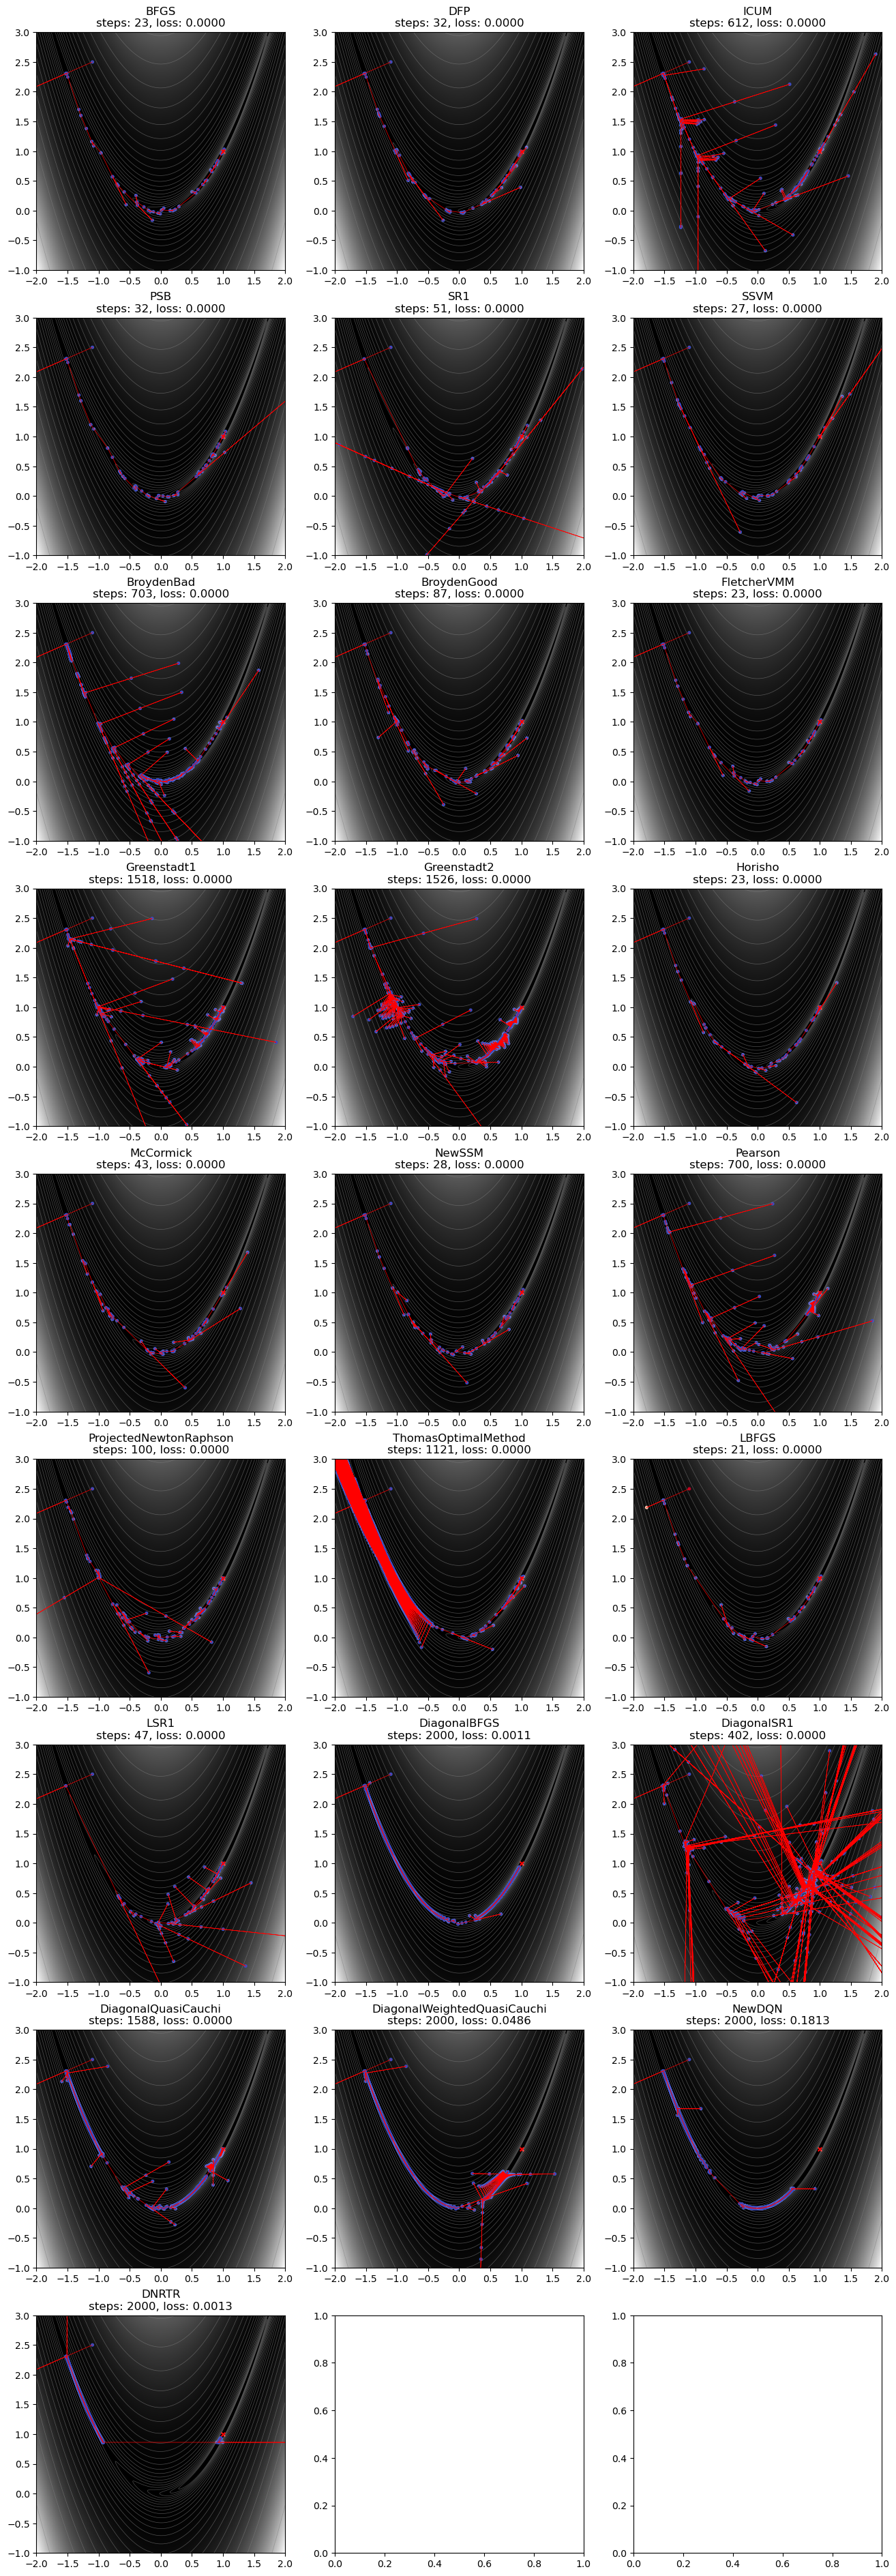

In [2]:
fig, axes = plt.subplots(ncols=3, nrows=9, figsize=(16,48))
axes = np.ravel(axes)
axes_iter = iter(axes)

for QN in (
    # full-matrix
    tz.m.BFGS,
    tz.m.DFP,
    tz.m.ICUM,
    tz.m.PSB,
    tz.m.SR1,
    tz.m.SSVM,
    tz.m.BroydenBad,
    tz.m.BroydenGood,
    tz.m.FletcherVMM,
    tz.m.Greenstadt1,
    tz.m.Greenstadt2,
    tz.m.Horisho,
    tz.m.McCormick,
    tz.m.NewSSM,
    tz.m.Pearson,
    tz.m.ProjectedNewtonRaphson,
    tz.m.ThomasOptimalMethod,

    # limited-memory
    tz.m.LBFGS,
    tz.m.LSR1,

    # diagonal
    tz.m.DiagonalBFGS,
    tz.m.DiagonalSR1,
    tz.m.DiagonalQuasiCauchi,
    tz.m.DiagonalWeightedQuasiCauchi,
    tz.m.NewDQN,
    tz.m.DNRTR,
    ):
    ax = next(axes_iter)
    func = FunctionDescent("rosen").set_print_inverval(None)
    optimizer = tz.Modular(
        func.parameters(),
        tz.m.RestartOnStuck(QN()),
        tz.m.StrongWolfe(c2=0.1),
    )

    func.run(optimizer, max_steps=2000, target_loss=1e-5)
    func.plot(log_contour=True, ax=ax)
    ax.set_title(f"{QN.__name__}\nsteps: {func.num_steps}, loss: {func.lowest_loss:.4f}")


plt.show()

### QN with trust region
QN methods can use two main trust regions - `TrustCG`, which uses a CG solver that terminates when solution exceeds trust radius, or `LevenbergMarquardt` which adds a scaled identity matrix. It is also possible to use `CubicRegularization`, although it tends to work better with exact hessian.

In all cases in order for a QN method to be used in trust region, it must maintain hessian approximation $B$, not the inverse $H$. In full-matrix methods this is achieved by passing ``inverse=False``. In torchzero formula for $B$ isn't implemented on all methods, but ones where it is implemented are listed below. Diagonal methods work and do not need the ``inverse=False`` argument. Limited-memory methods only support `TrustCG`.

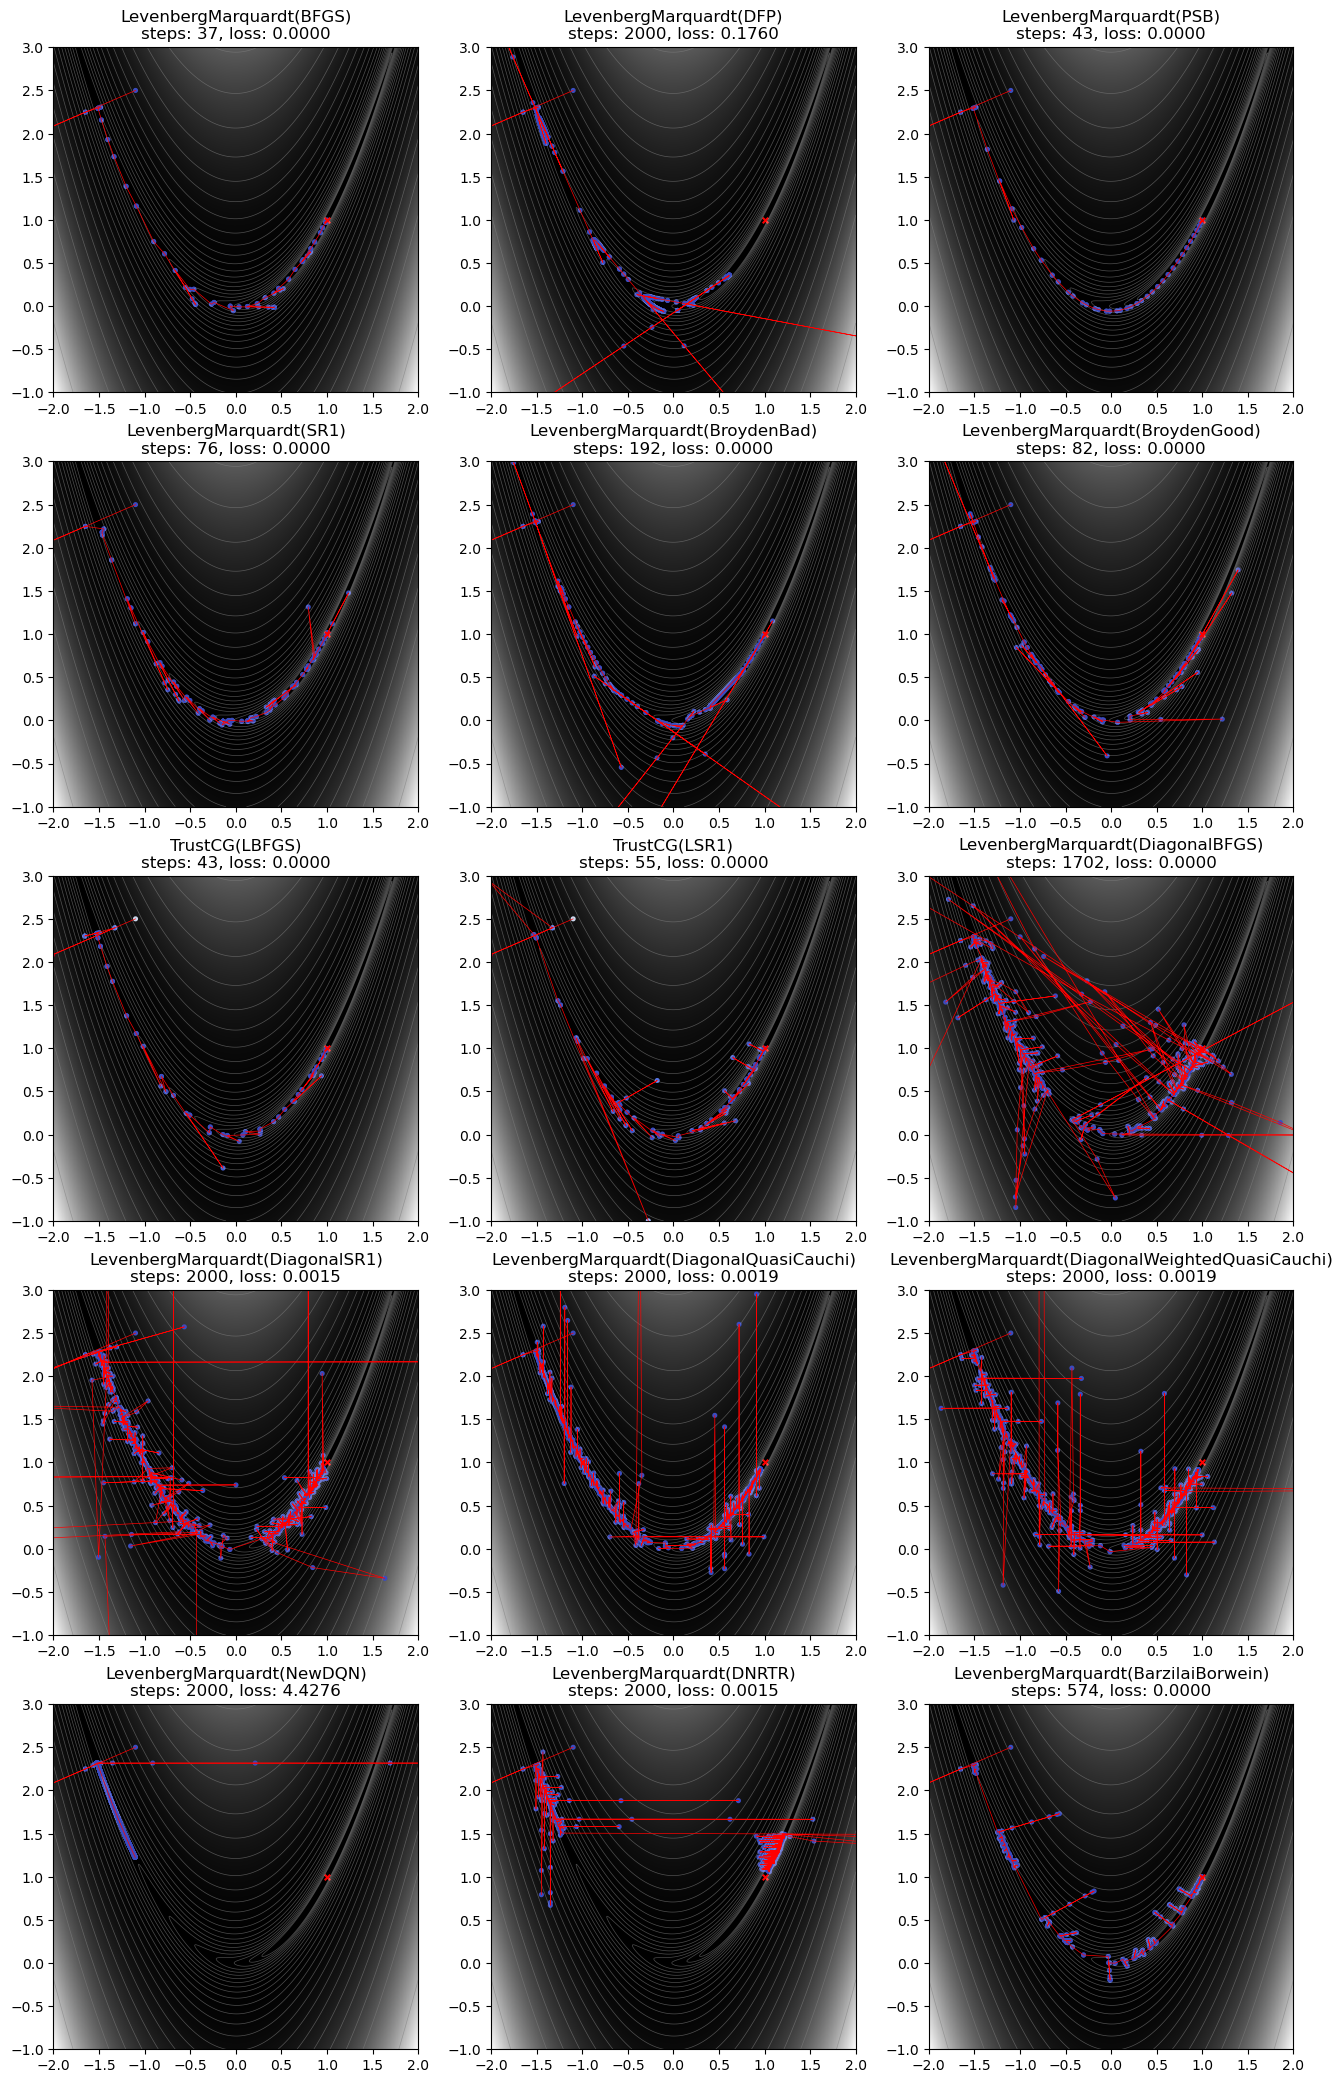

In [3]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(16,26))
axes = np.ravel(axes)
axes_iter = iter(axes)

for QN in (
    # full-matrix
    tz.m.BFGS,
    tz.m.DFP,
    tz.m.PSB,
    tz.m.SR1,
    tz.m.BroydenBad,
    tz.m.BroydenGood,

    # limited-memory
    tz.m.LBFGS,
    tz.m.LSR1,

    # diagonal
    tz.m.DiagonalBFGS,
    tz.m.DiagonalSR1,
    tz.m.DiagonalQuasiCauchi,
    tz.m.DiagonalWeightedQuasiCauchi,
    tz.m.NewDQN,
    tz.m.DNRTR,

    # scalar approximation to quasi-newton methods
    tz.m.BarzilaiBorwein,
    ):
    ax = next(axes_iter)
    func = FunctionDescent("rosen").set_print_inverval(None)

    # pass inverse=False only to full-matrix methods
    if QN in (tz.m.DiagonalBFGS, tz.m.DiagonalSR1, tz.m.DiagonalQuasiCauchi, tz.m.DiagonalWeightedQuasiCauchi, tz.m.NewDQN, tz.m.DNRTR, tz.m.LBFGS, tz.m.LSR1, tz.m.BarzilaiBorwein):
        qn = QN()
    else:
        qn = QN(inverse=False)

    # use trust CG for L-BFGS and L-SR1, and LevenbergMarquardt for rest
    if QN in (tz.m.LBFGS, tz.m.LSR1):
        TrustRegion = tz.m.TrustCG
    else:
        TrustRegion = tz.m.LevenbergMarquardt

    optimizer = tz.Modular(
        func.parameters(),
        TrustRegion(
            tz.m.RestartOnStuck(qn),
        )
    )

    func.run(optimizer, max_steps=2000, target_loss=1e-5)

    func.plot(log_contour=True, ax=ax)
    ax.set_title(f"{TrustRegion.__name__}({QN.__name__})\nsteps: {func.num_steps}, loss: {func.lowest_loss:.4f}")


plt.show()